In [1]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))

# Import the volatility analysis library directly
from volatility_lib import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance

In [2]:
# Configuration parameters
FETCH_DATA = True  # Set to True to fetch new news data
FROM = "2024-01-01"
TO = "2025-12-31"
CUT = "2024-10-01"  # Date to split train/test data
TOPIC = "BUSINESS"
MARKET_NAME = "IBEX 35"

In [3]:
keywords = [
    "IBEX",  # IBEX 35
    "Banco de España",  # Banco de España
    "Tipos de interés",  # Tipos de interés
    "Inflación",  # Inflación
    "PIB",  # PIB
    "Crecimiento económico",  # Crecimiento económico
    "Crisis económica",  # Crisis económica
    "Recesión",  # Recesión
    "Recuperación económica",  # Recuperación económica
    "Mercado de valores",  # Mercado de valores
    "Inversión",  # Inversión
    "Renta variable",  # Renta variable
    "Renta fija",  # Renta fija
    "Bonos",  # Bonos
    "Bolsa de Madrid",  # Madrid Stock Exchange
    "Empresas del IBEX",  # IBEX companies
    "Economía española",  # Spanish economy
    "Desempleo",  # Unemployment
    "Euro",  # Euro
    "Deuda española",  # Spanish debt
    "BCE",  # European Central Bank
    "Banco Central Europeo",  # European Central Bank
    "Política monetaria",  # Monetary policy
    "Política fiscal",  # Fiscal policy
    "Crisis financiera",  # Financial crisis
]

In [4]:
# Fetch news data function
def fetch_ibex_news_data():
    from pygooglenews import GoogleNews
    
    # Helper function to convert news to DataFrame
    def convert_to_dataframe(news):
        data = []
        for article in news['entries']:
            try:
                # Try the original format first
                date = datetime.strptime(article['published'], '%a, %d %b %Y %H:%M:%S %Z')
            except ValueError:
                # If that fails, use pd.to_datetime which is more flexible
                date = pd.to_datetime(article['published'])
                # Convert timezone-aware datetime to timezone-naive
                if date.tzinfo is not None:
                    date = date.replace(tzinfo=None)
            title = article['title']
            data.append({'date': date, 'title': title})
        return pd.DataFrame(data)
    
    # Create Google News instance
    gn = GoogleNews(lang="es", country="ES")
    
    # Search for news with the keywords
    news = gn.search(
        query=" OR ".join(keywords),
        from_=FROM,
        to_=TO,
    )
    
    # Convert to DataFrame
    df = convert_to_dataframe(news)
    df['date'] = pd.to_datetime(df['date'])
    
    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    df.to_csv(f"../news/news_data_{FROM}_{TO}_IBEX.csv", index=False)
    
    return df

In [5]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_ibex_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_IBEX.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Fetched 60 news articles


In [6]:
# Fetch IBEX 35 market data using yfinance
ibex35 = yfinance.Ticker("^IBEX")
ibex35_data = ibex35.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
ibex35_data = ibex35_data.reset_index()  # Convert index to column
ibex35_data = ibex35_data[["Date", "Close"]].copy()
ibex35_data["Returns"] = ibex35_data["Close"].pct_change()
ibex35_data["Volatility"] = ibex35_data["Returns"].rolling(window=21).std() * np.sqrt(252)
ibex35_data = ibex35_data.dropna().reset_index(drop=True)

print(f"Loaded {len(ibex35_data)} days of IBEX 35 market data")
ibex35_data.head()

Loaded 332 days of IBEX 35 market data


,Date,Close,Returns,Volatility
0,2024-01-31 00:00:00+01:00,10077.700195,0.003825,0.141555
1,2024-02-01 00:00:00+01:00,10014.000000,-0.006321,0.136295
2,2024-02-02 00:00:00+01:00,10062.500000,0.004843,0.129338
3,2024-02-05 00:00:00+01:00,9941.299805,-0.012045,0.135336
4,2024-02-06 00:00:00+01:00,10003.000000,0.006206,0.136400


Calculating sentiment scores...


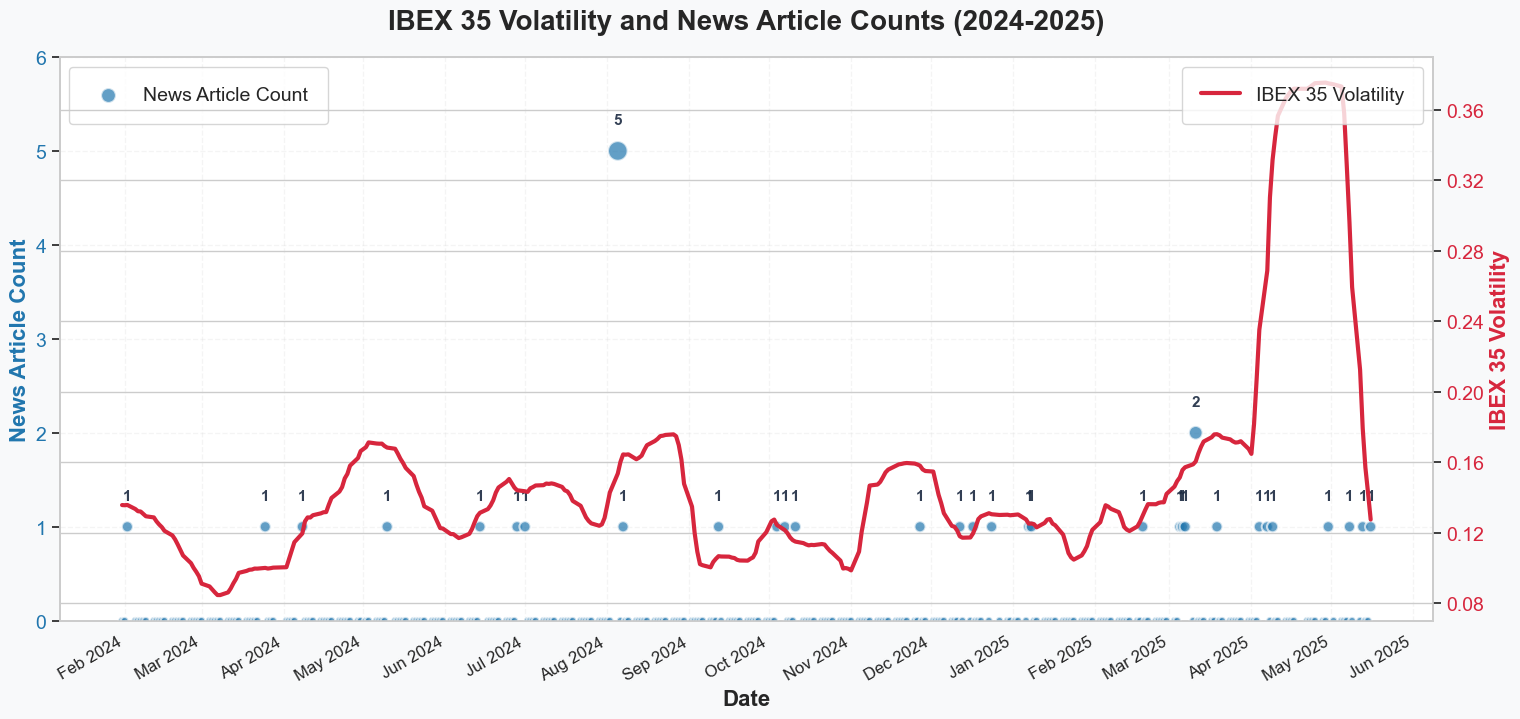

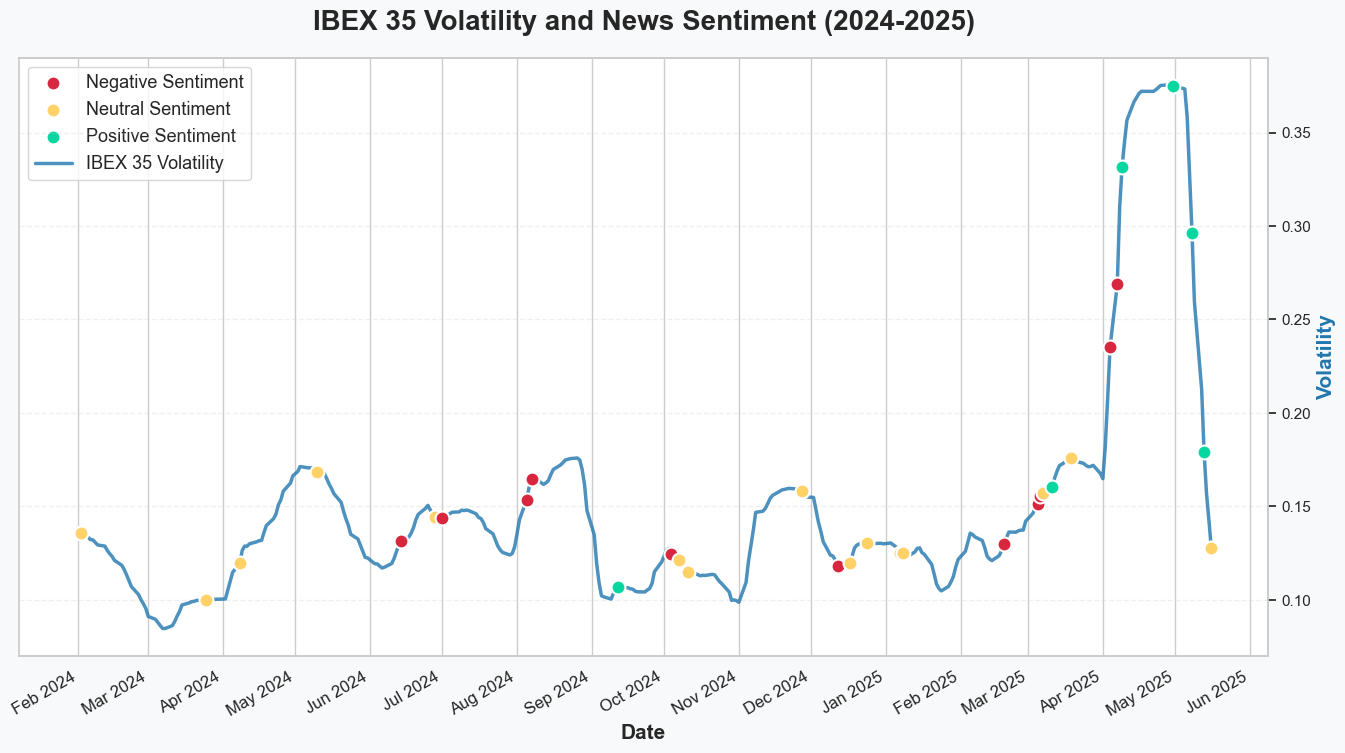

Splitting data at 2024-10-01...
Preparing data for LSTM model...
Training LSTM model with 50 epochs...
Epoch 1/50, Loss: 0.29303
Epoch 10/50, Loss: 0.02183
Epoch 20/50, Loss: 0.00928
Epoch 30/50, Loss: 0.00648
Epoch 40/50, Loss: 0.00384
Epoch 50/50, Loss: 0.00339
Evaluating LSTM model...
Model Performance Metrics:
MSE: 0.001672
RMSE: 0.040892
MAE: 0.020144
R² Score: 0.737329


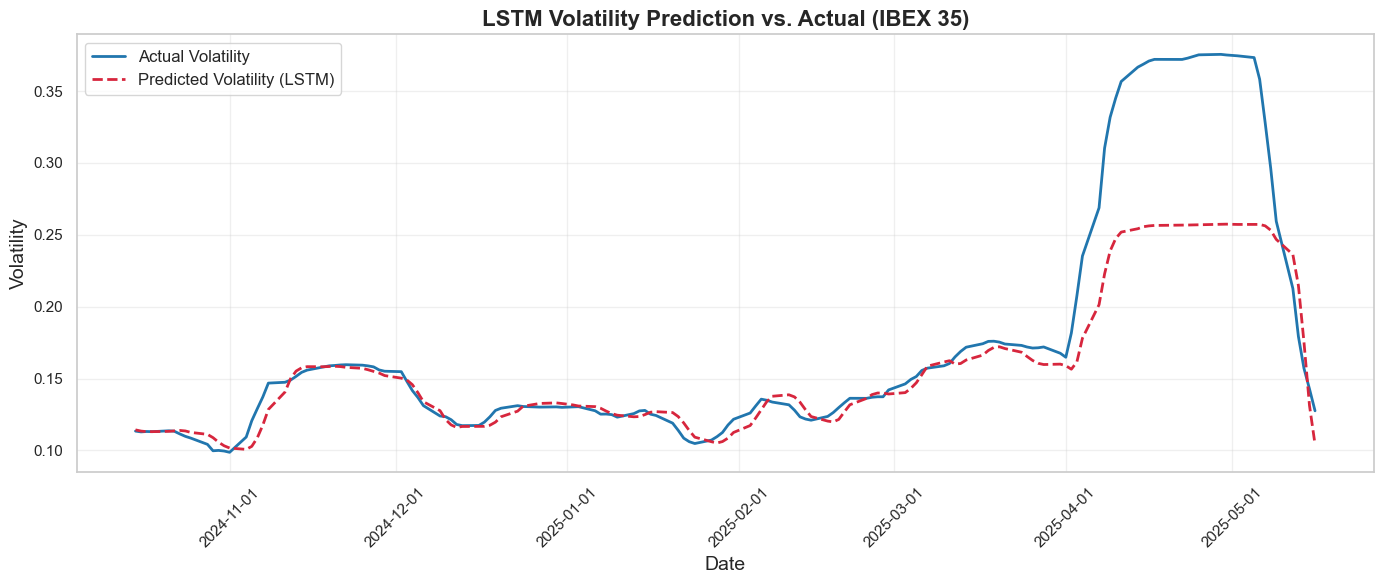

In [7]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=ibex35_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    verbose=True
)

In [8]:
# Display model metrics
metrics = results['metrics']
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.6f}")

MSE: 0.001672
RMSE: 0.040892
MAE: 0.020144
R2: 0.737329


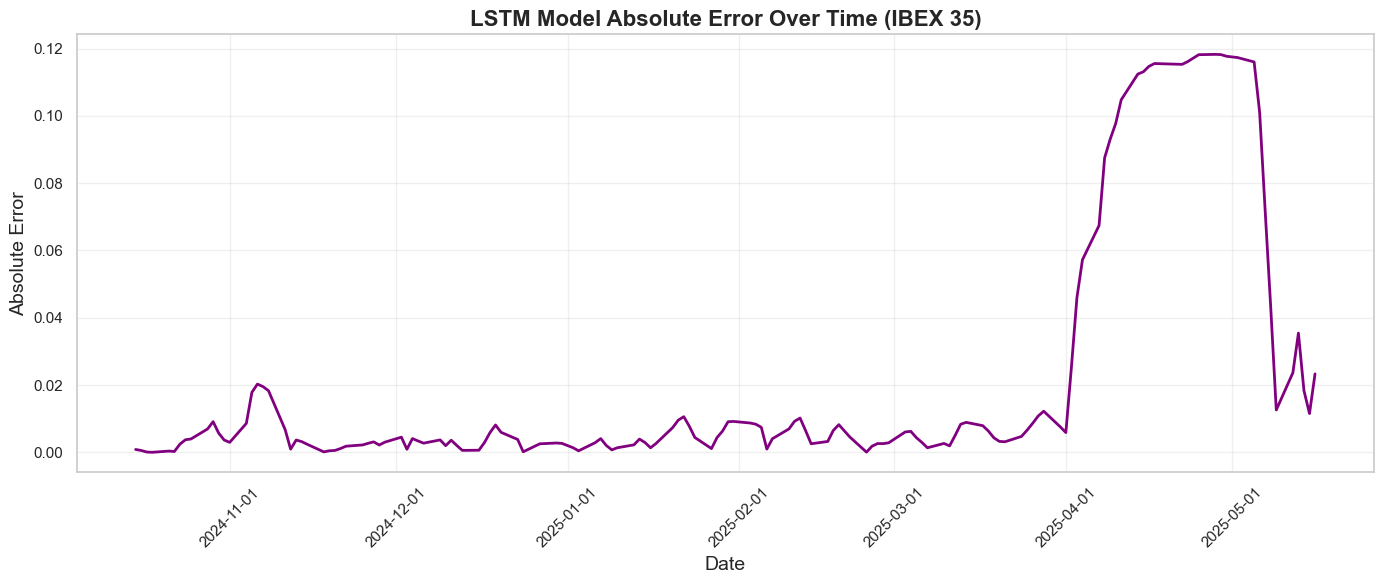

In [9]:
# Example: Creating a custom visualization of the model error over time
error = np.abs(results['y_actual'] - results['y_pred'])
plt.figure(figsize=(14, 6))
plt.plot(results['test_dates'], error, color='purple', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (IBEX 35)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../news/ibex35_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()